<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> K-Means Formula 1 2021 Tracks from telemetry Data </center></h3>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install fastf1
!pip install altair
!pip install yellowbrick

In [12]:
from operator import index
import fastf1
import numpy as np
import matplotlib as mpl
import pandas as pd
import altair as alt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
from fastf1.core import *

pd.set_option("display.precision", 2)
fastf1.Cache.enable_cache("./MasterSSIO/Clustering/")  # replace with your cache directory


<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> Help Files </center></h3>

In [11]:
'''On a remplacer dans ces fonctions qui suivent, "weekend.name" par "event.Eventname"'''

'''
Cette fonction prend un DataFrame df et modifie ses positions d'index en décalant les éléments avant la première occurrence de la valeur 1 dans la colonne "str_cor".
Elle assure que les indices inférieurs à cette première occurrence sont déplacés vers la fin du DataFrame, réorganise le DataFrame en fonction des nouveaux indices,
puis supprime la colonne temporaire "Index" avant de renvoyer le DataFrame modifié.
'''
def change_initial_position(df):
    df["Index"] = df.index
    first_corner = df[df["str_cor"] == 1].groupby(["str_cor"])["Index"].min().sum()
    df["Index"] = np.where(
        df["Index"] < first_corner, df["Index"] + df["Index"].max(), df["Index"]
    )
    df = df.sort_values(by=["Index"]).reset_index(drop=True)
    del df["Index"]
    return df

'''
Cette fonction pick_fastest_driver_of_session prend un DataFrame laps représentant des tours de course.
Elle itère sur les pilotes dans le DataFrame, récupère le temps du tour le plus rapide pour chaque pilote,
et détermine le pilote ayant le temps de tour le plus rapide. Les résultats renvoyés sont le temps du tour le plus rapide,
le nom du pilote correspondant et le type de pneu (Compound) utilisé pour ce tour.
Si un pilote n'a pas de temps valide, il est ignoré dans le processus de sélection du pilote le plus rapide.
'''
def pick_fastest_driver_of_session(laps):
    drivers = pd.unique(laps["Driver"])
    counter = 1
    for drv in drivers:
        if counter == 1:
            fastestlap = laps.pick_driver(drv).pick_fastest()["LapTime"]
            best_driver = laps.pick_driver(drv).pick_fastest()["Driver"]
        else:
            try:
                if laps.pick_driver(drv).pick_fastest()["LapTime"] <= fastestlap:
                    fastestlap = laps.pick_driver(drv).pick_fastest()["LapTime"]
                    best_driver = laps.pick_driver(drv).pick_fastest()["Driver"]
                else:
                    pass
            except:
                pass
        counter = counter + 1
    compound = laps.pick_driver(best_driver).pick_fastest()["Compound"]
    return fastestlap, best_driver, compound

'''
Cette fonction print_the_best_driver prend trois paramètres : session, fastestlap, et best_driver.
Elle imprime à la console un message formaté indiquant le nom de l'événement (session.event.EventName),
le pilote ayant réalisé le tour le plus rapide (best_driver), et le temps de ce tour (fastestlap).
Le message est composé en concaténant ces informations dans une chaîne de caractères.
'''
def print_the_best_driver(session, fastestlap, best_driver):
    print(
        session.event.EventName
        + " fastest lap is "
        + best_driver
        + " with time "
        + str(fastestlap)
    )

'''
La fonction load_best_lap prend en paramètres un DataFrame laps représentant les tours de course et le nom du meilleur pilote best_driver.
Elle extrait et prépare ensuite les données de télémétrie spécifiques au tour le plus rapide du pilote sélectionné.
'''
def load_best_lap(laps, best_driver):
    df = laps.pick_driver(best_driver).pick_fastest().telemetry
    df = pd.DataFrame(df)
    df = df[df["Source"] == "car"].reset_index(drop=True)
    print(df.columns)
    df = df[
        [
            "Date",
            "RPM",
            "Speed",
            "nGear",
            "Throttle",
            "Brake",
            "DRS",
            "Distance",
            "X",
            "Y",
            "Z",
        ]
    ]

    return df

'''
La fonction flags_strcor_based_on_normal_speed prend un DataFrame df contenant des données de vitesse.
Elle crée deux nouvelles colonnes : "normalizedspeed" représente la moyenne roulante de la vitesse sur une fenêtre de 4 tours,
et "str_cor" marque les changements soudains de vitesse. Les tours où la différence de vitesse avec le tour précédent est
supérieure à 3 sont marqués comme des zones de changement de corde ("str_cor" = 1). Cependant,
pour éviter de compter plusieurs tours consécutifs comme des changements de corde, la fonction ajuste ces marques
en considérant uniquement les tours où "str_cor" est égal à 1 et n'est pas précédé ni suivi immédiatement
par un autre "str_cor" égal à 1. Le DataFrame modifié est ensuite renvoyé.
'''
def flags_strcor_based_on_normal_speed(df):
    df["normalizedspeed"] = df["Speed"].rolling(window=4, min_periods=1).mean()
    df["str_cor"] = np.where(
        (df["normalizedspeed"].shift(1) - df["normalizedspeed"]) > 3, 1, 0
    )
    df["str_cor"] = np.where(
        (df["str_cor"] == 1)
        & (df["str_cor"].shift(1) != 1)
        & (df["str_cor"].shift(-1) != 1),
        0,
        (df["str_cor"]),
    )
    return df

'''
La fonction order_data prend un DataFrame df et crée une nouvelle colonne "No" qui contient l'ordre original des indices
du DataFrame. En d'autres termes, elle assigne à chaque ligne un numéro correspondant à son indice d'origine dans le DataFrame.
Cette colonne "No" permet de conserver l'ordre initial des données, même après d'autres opérations ou transformations sur le DataFrame.
La fonction renvoie le DataFrame modifié avec la nouvelle colonne "No".
'''
def order_data(df):
    # Create Order of data
    df["No"] = df.index
    return df

'''
La fonction counter_strcor ajoute deux nouvelles colonnes au DataFrame df : "counter_straights" et "counter_corners".
Ces colonnes comptent respectivement le nombre de lignes consécutives représentant des lignes droites et des virages dans les données.
'''
def counter_strcor(df):
    df["counter_straights"] = np.nan
    df["counter_corners"] = np.nan
    for index, rows in df.iterrows():
        if df.loc[index, "No"] == 0:
            if df.loc[index, "str_cor"] == 0:
                df.at[index, "counter_straights"] = 1
                df.at[index, "counter_corners"] = 0
            elif df.loc[index, "str_cor"] == 1:
                df.at[index, "counter_straights"] = 0
                df.at[index, "counter_corners"] = 1
        elif df.loc[index, "str_cor"] == previous_str_cor:
            df.at[index, "counter_straights"] = previous_counter_straights
            df.at[index, "counter_corners"] = previous_counter_corners
        elif df.loc[index, "str_cor"] == 1:
            df.at[index, "counter_straights"] = previous_counter_straights
            df.at[index, "counter_corners"] = previous_counter_corners + 1
        elif df.loc[index, "str_cor"] == 0:
            df.at[index, "counter_straights"] = previous_counter_straights + 1
            df.at[index, "counter_corners"] = previous_counter_corners
        previous_str_cor = df.loc[index, "str_cor"]
        previous_counter_straights = df.loc[index, "counter_straights"]
        previous_counter_corners = df.loc[index, "counter_corners"]
    return df

'''
Cette fonction crée un graphique à dispersion où chaque point représente une position sur la piste de course,
avec les axes X et Y déterminés par les colonnes "X" et "Y" du DataFrame. Les points sont colorés en fonction de la colonne
"str_cor" (0 pour les lignes droites, 1 pour les virages), et l'ordre des points est déterminé par la colonne "No".
La fonction affiche ensuite le graphique avec le titre de l'événement de la session.
'''
def track_vizualization(session, df):
    chart = (
        alt.Chart(df)
        .mark_circle()
        .encode(
            alt.X("X", scale=alt.Scale(zero=False), axis=None),
            alt.Y("Y", scale=alt.Scale(zero=False), axis=None),
            order="No",
            color=alt.Color(
                "str_cor",
                scale=alt.Scale(domain=[0, 1], range=["#028A0F", "#B90E0A"]),
                legend=None,
            ),
        )
        .configure_axis(grid=False)
        .configure_view(strokeWidth=0)
        .properties(title=session.event.EventName)
        .configure_title(fontSize=20, anchor="middle", color="#404040")
    )
    chart.display()

'''
La fonction corner_counter_speeds effectue une analyse des virages en fonction de la vitesse dans le DataFrame df.
Elle regroupe les données par le compteur de virages (counter_corners), trouve la vitesse minimale pour chaque groupe,
puis catégorise ces vitesses minimales dans des intervalles définis.
Ensuite, elle crée une nouvelle colonne grp_corner en fonction de ces intervalles de vitesse.
Elle utilise des conditions imbriquées avec np.where pour définir ces catégories (50, 100, 150, 200, 250, 300, 350, et "error"
pour toutes les autres vitesses). Enfin, la fonction effectue une pivot table pour compter le nombre de virages
dans chaque catégorie de vitesse. Elle renvoie un DataFrame avec les résultats, où les colonnes représentent différentes
catégories de vitesses pour les virages.
'''
def corner_counter_speeds(df):
    corner_analysis = (
        df.groupby("counter_corners")
        .min("Speed")
        .reset_index()[["counter_corners", "Speed"]]
    )

    corner_analysis["grp_corner"] = np.where(
        corner_analysis["Speed"] <= 50,
        "50",
        np.where(
            corner_analysis["Speed"] <= 100,
            "100",
            np.where(
                corner_analysis["Speed"] <= 150,
                "150",
                np.where(
                    corner_analysis["Speed"] <= 200,
                    "200",
                    np.where(
                        corner_analysis["Speed"] <= 250,
                        "250",
                        np.where(
                            corner_analysis["Speed"] <= 300,
                            "300",
                            np.where(corner_analysis["Speed"] <= 350, 350, "error"),
                        ),
                    ),
                ),
            ),
        ),
    )

    corner_analysis = pd.pivot_table(
        corner_analysis, columns="grp_corner", values="counter_corners", aggfunc="count"
    ).reset_index()
    corner_analysis = corner_analysis[[x for x in corner_analysis.columns if "0" in x]]

    corner_analysis_columns = ["cor_" + x for x in corner_analysis.columns if "0" in x]
    corner_analysis.columns = corner_analysis_columns
    return corner_analysis

'''
La fonction straight_counter_speeds effectue une analyse des lignes droites en fonction de la vitesse dans le DataFrame df.
Elle regroupe les données par le compteur de lignes droites (counter_straights), trouve la vitesse maximale pour chaque groupe,
puis catégorise ces vitesses maximales dans des intervalles définis.
Ensuite, elle crée une nouvelle colonne grp_straights en fonction de ces intervalles de vitesse.
Elle utilise des conditions imbriquées avec np.where pour définir ces catégories (50, 100, 150, 200, 250, 300, 350, et "error"
pour toutes les autres vitesses). Enfin, la fonction effectue une pivot table pour compter le nombre de lignes droites dans
chaque catégorie de vitesse. Elle renvoie un DataFrame avec les résultats, où les colonnes représentent différentes catégories
de vitesses pour les lignes droites.
'''
def straight_counter_speeds(df):
    temp_df = (
        df.groupby("counter_straights")
        .max("Speed")
        .reset_index()[["counter_straights", "Speed"]]
    )

    temp_df["grp_straights"] = np.where(
        temp_df["Speed"] <= 50,
        "50",
        np.where(
            temp_df["Speed"] <= 100,
            "100",
            np.where(
                temp_df["Speed"] <= 150,
                "150",
                np.where(
                    temp_df["Speed"] <= 200,
                    "200",
                    np.where(
                        temp_df["Speed"] <= 250,
                        "250",
                        np.where(
                            temp_df["Speed"] <= 300,
                            "300",
                            np.where(temp_df["Speed"] <= 350, 350, "error"),
                        ),
                    ),
                ),
            ),
        ),
    )

    temp_df = pd.pivot_table(
        temp_df, columns="grp_straights", values="counter_straights", aggfunc="count"
    ).reset_index()
    temp_df = temp_df[[x for x in temp_df.columns if "0" in x]]

    temp_df_columns = ["str_" + x for x in temp_df.columns if "0" in x]
    temp_df.columns = temp_df_columns
    return temp_df

'''
La fonction dataframe_creation prend un DataFrame représentant des tours de course (laps) et le meilleur pilote (best_driver).
Elle effectue une séquence d'opérations, incluant le chargement du meilleur tour, l'ajout d'indicateurs de changement de corde basés
sur la vitesse, la modification de la position initiale, la création d'une colonne d'ordre, et le comptage des sections de lignes
droites et de virages consécutifs. Le résultat est un DataFrame transformé reflétant ces informations.
'''
def dataframe_creation(laps, best_driver):
    df = load_best_lap(laps, best_driver)
    df = flags_strcor_based_on_normal_speed(df)
    df = change_initial_position(df)
    df = order_data(df)
    df = counter_strcor(df)
    return df

'''
La fonction retrieve_kpis prend une session de course (session), le tour le plus rapide (fastestlap), et un DataFrame de données (df).
Elle calcule plusieurs indicateurs clés de performance tels que le pourcentage de temps en pleine accélération, la distance totale
parcourue, la vitesse maximale, la vitesse moyenne, ainsi que le nombre de virages et de lignes droites dans différentes catégories de
vitesse. Ces KPIs sont agrégés dans un nouveau DataFrame avec le nom du Grand Prix, et le résultat est renvoyé.
'''
def retreive_kpis(session, fastestlap, df):
    temporary_df = pd.DataFrame()
    df["_Full_Throttle"] = np.where(df["Throttle"] >= 95, 1, 0)
    distance = df.Distance.max()
    avg_speed = distance / 1000 / float(fastestlap / np.timedelta64(1, "h"))
    max_speed = df.Speed.max()
    perc_full_throttle = df["_Full_Throttle"].sum() / df["_Full_Throttle"].count()
    df_corners = corner_counter_speeds(df)
    df_straights = straight_counter_speeds(df)
    temporary_df = pd.concat([temporary_df, df_corners, df_straights], axis=1)
    temporary_df["perc_full_throttle"] = perc_full_throttle
    temporary_df["distance"] = distance
    temporary_df["max_speed"] = max_speed
    temporary_df["avg_speed"] = avg_speed
    temporary_df["grandprix"] = session.event.EventName
    return temporary_df

'''
La fonction Preparing_df_for_kmeans remplit les valeurs manquantes avec 0, exclut les données du "Styrian Grand Prix",
sélectionne certaines colonnes spécifiques pour l'analyse K-means, réinitialise l'index du DataFrame résultant,
et convertit certaines colonnes en catégories numériques pour préparer les données pour l'algorithme K-means.
'''
def Preparing_df_for_kmeans(df):
    df = df.fillna(0)
    df = df[df["grandprix"] != "Styrian Grand Prix"]
    df = df[
        [
            "grandprix",
            "max_speed",
            "avg_speed",
            "distance",
            "perc_full_throttle",
            "cor_50",
            "cor_100",
            "cor_150",
            "cor_200",
            "cor_250",
            "cor_300",
            "str_150",
            "str_200",
            "str_250",
            "str_300",
            "str_350",
        ]
    ].reset_index(drop=True)
    kmeans_df = df.drop(columns="grandprix")
    columnslist = [
        "cor_50",
        "cor_100",
        "cor_150",
        "cor_200",
        "cor_250",
        "cor_300",
        "str_150",
        "str_200",
        "str_250",
        "str_300",
        "str_350",
    ]

    for col in columnslist:
        kmeans_df[col] = kmeans_df[col].astype("int")
        kmeans_df[col] = kmeans_df[col].astype("category")
    return df, kmeans_df

'''
La fonction onehotencoder_method applique la méthode d'encodage one-hot aux colonnes spécifiées dans la liste onehotcolumns du
DataFrame kmeans_df. Elle utilise la classe OneHotEncoder de scikit-learn avec l'option "ignore" pour gérer les catégories inconnues.
Le résultat est un DataFrame modifié avec des colonnes one-hot pour les catégories spécifiées.
'''
def onehotencoder_method(kmeans_df):
    onehotcolumns = [
        "cor_50",
        "cor_100",
        "cor_150",
        "cor_200",
        "cor_250",
        "cor_300",
        "str_150",
        "str_200",
        "str_250",
        "str_300",
        "str_350",
    ]
    enc = OneHotEncoder(handle_unknown="ignore")
    kmeans_df = pd.get_dummies(kmeans_df, columns=onehotcolumns)
    return kmeans_df

'''
La fonction minmaxscaler_method applique la méthode de mise à l'échelle Min-Max aux données du DataFrame kmeans_df.
Elle utilise le MinMaxScaler de scikit-learn pour mettre à l'échelle les valeurs entre 0 et 1.
Le résultat est un DataFrame modifié avec les données normalisées.
'''
def minmaxscaler_method(kmeans_df):
    x = kmeans_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    kmeans_df = pd.DataFrame(x_scaled)
    return kmeans_df

'''
La fonction track_vizualization_byCluster utilise la bibliothèque Altair pour créer une visualisation interactive de la piste
de course en fonction des clusters. Elle prend un DataFrame df contenant des informations sur la piste et des clusters associés,
ainsi que le nom de la piste (track). Le graphique à dispersion (scatter plot) est coloré en fonction des clusters,
avec des couleurs spécifiques définies dans la fonction. Le titre du graphique est également défini par le nom de la piste.
La fonction affiche ensuite le graphique.
'''
def track_vizualization_byCluster(df, track):
    chart = (
        alt.Chart(df)
        .mark_circle()
        .encode(
            alt.X("X", scale=alt.Scale(zero=False), axis=None),
            alt.Y("Y", scale=alt.Scale(zero=False), axis=None),
            order="No",
            color=alt.Color(
                "Cluster",
                scale=alt.Scale(
                    domain=[0, 1, 2, 3, 4, 5,6,7],
                    range=[
                        "#1B1A17",
                        "#F0A500",
                        "#5463FF",
                        "#7C203A",
                        "#468966",
                        "#573391",
                        "#A4D792",
                        "#EB2632",
                    ],
                ),
                legend=None,
            ),
        )
        .configure_axis(grid=False)
        .configure_view(strokeWidth=0)
        .properties(title=track)
        .configure_title(fontSize=20, anchor="middle", color="#404040")
    )
    chart.display()

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> Data Download </center></h3>

In [13]:
df = pd.DataFrame()
tracks_points = pd.DataFrame()
for i in range(1, 23):
    # Loading Data for each race
    session = fastf1.get_session(2021, i, "Q")
    session.load()
    laps = session.laps
    # Retrieving the best lap
    fastestlap, best_driver, compound = pick_fastest_driver_of_session(laps)
    # Excluding sessions in wet conditions
    if (compound == "WET") | (compound == "INTERMEDIATE"):
        pass
    else:
        print_the_best_driver(session, fastestlap, best_driver)
        # Retrieving Telemetry data only for the fastest driver
        track_df = dataframe_creation(laps, best_driver)
        # Visualize track
        track_vizualization(session, track_df)
        # Creating the Dimensions that we need to use
        track_df_new = retreive_kpis(session, fastestlap, track_df)
        track_df["grandprix"] = session.event.EventName
        # Creating a dataframe with all races
        tracks_points = pd.concat([tracks_points, track_df])
        # Creating a dataframe with the dimensions that we need for K-Means
        df = pd.concat([df, track_df_new])

Output hidden; open in https://colab.research.google.com to view.

In [14]:
df

,cor_100,cor_150,cor_200,cor_250,str_300,str_350,perc_full_throttle,distance,max_speed,avg_speed,grandprix,str_200,str_250,cor_50,str_150,cor_300
0,3.0,3,1.0,1.0,6,3.0,0.64,5391.20,315,218.08,Bahrain Grand Prix,NaN,NaN,NaN,NaN,NaN
0,NaN,4,3.0,1.0,7,1.0,0.73,4899.32,322,237.03,Emilia Romagna Grand Prix,1.0,NaN,NaN,NaN,NaN
0,3.0,3,NaN,1.0,5,2.0,0.60,4637.67,319,214.13,Portuguese Grand Prix,1.0,NaN,NaN,NaN,NaN
0,1.0,4,3.0,NaN,3,2.0,0.64,4665.11,316,218.85,Spanish Grand Prix,1.0,3.0,NaN,NaN,NaN
0,6.0,3,2.0,NaN,4,NaN,0.45,3276.66,287,167.69,Monaco Grand Prix,2.0,4.0,1.0,3.0,NaN
0,7.0,4,NaN,NaN,5,3.0,0.62,5941.76,333,211.33,Azerbaijan Grand Prix,NaN,2.0,NaN,2.0,NaN
0,2.0,3,3.0,NaN,3,4.0,0.61,5758.14,329,230.35,French Grand Prix,2.0,NaN,NaN,NaN,NaN
0,1.0,1,2.0,2.0,4,4.0,0.72,4296.87,321,242.30,Styrian Grand Prix,NaN,NaN,NaN,NaN,1.0
0,1.0,1,1.0,3.0,4,4.0,0.72,4287.61,320,242.24,Austrian Grand Prix,NaN,NaN,NaN,NaN,1.0
0,1.0,3,1.0,2.0,2,3.0,0.69,5824.00,325,243.73,British Grand Prix,2.0,1.0,NaN,NaN,NaN


In [ ]:
#df.to_csv('df_GP.csv')
# df.to_csv('./sample_data/df_GP.csv')

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> K-Means Data </center></h3>

<div class="alert alert-block alert-info">
<b>Tips:</b> Use functions : Preparing_df_for_kmeans, onehotencoder_method, minmaxscaler_method
</div>

In [39]:
# On prepare nos données pour l'algorithme du kmeans
prep_df,kmeans_prep_df = Preparing_df_for_kmeans(df)

print(kmeans_prep_df)

# Application de l'encodage one-hot aux données préparées pour le kmeans
kmeans_prep_df = onehotencoder_method(kmeans_prep_df)

print(kmeans_prep_df)

# Application de la mise à l'échelle Min-Max (normalisation) aux données préparées pour le kmeans
kmeans_prep_df = minmaxscaler_method(kmeans_prep_df)

print(kmeans_prep_df)

    max_speed  avg_speed  distance  perc_full_throttle cor_50 cor_100 cor_150  \
0         315     218.08   5391.20                0.64      0       3       3   
1         322     237.03   4899.32                0.73      0       0       4   
2         319     214.13   4637.67                0.60      0       3       3   
3         316     218.85   4665.11                0.64      0       1       4   
4         287     167.69   3276.66                0.45      1       6       3   
5         333     211.33   5941.76                0.62      0       7       4   
6         329     230.35   5758.14                0.61      0       2       3   
7         320     242.24   4287.61                0.72      0       1       1   
8         325     243.73   5824.00                0.69      0       1       3   
9         312     207.08   4338.21                0.57      0       1       5   
10        309     220.77   4224.31                0.64      0       0       6   
11        338     260.52   5

<div class="alert alert-block alert-info">
<b>Tips:</b> Use KElbowVisualizer
</div>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

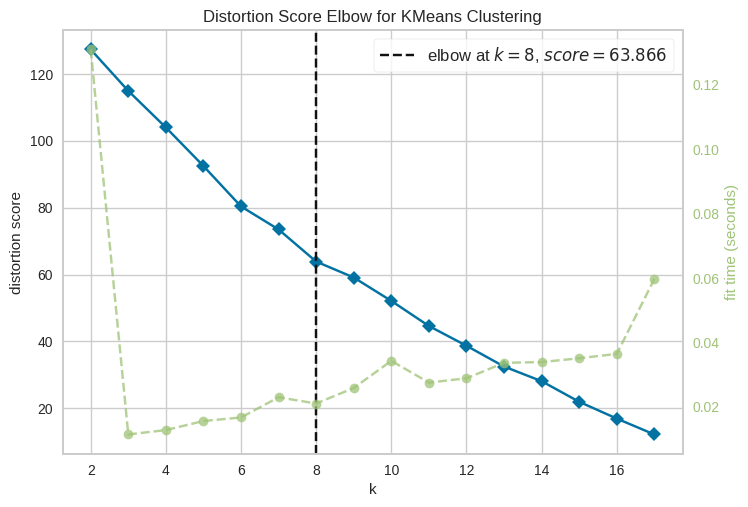

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# Création d'une instance kmeans
kmeans = KMeans()

# Visualisation des résultats en utilisant la méthode du "coude", afin de déterminer le k optimal du nombre de clusters
kelbow = KElbowVisualizer(kmeans, k=(2, 18), timings=True, metric="distortion", locate_elbow=True)
kelbow.fit(kmeans_prep_df)
kelbow.show()

La visualisation des résultats indique qu'un nombre optimal de clusters, égal à 8, offre un compromis judicieux. Cette sélection semble trouver un équilibre entre avoir trop peu de clusters, ce qui conduirait à une détection minimale de différences entre les circuits, et en avoir beaucoup, ce qui pourrait résulter de l'adaptation du modèle au bruit, une situation également indésirable. Dans ce contexte spécifique et avec nos données, le choix de 8 clusters s'avère être une décision appropriée pour notre modèle.

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> Apply K-Means on dataframe with the selected k </center></h3>

<div class="alert alert-block alert-info">
<b>Tip:</b> Use KMeans,fit, fit_predict
</div>

In [18]:
kmeans = KMeans(kelbow.elbow_value_)
kmeans.fit(kmeans_prep_df)
clusters = kmeans.fit_predict(kmeans_prep_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> Strore in dataFrame K-Means results</center></h3>

<div class="alert alert-block alert-info">
<b>Tip:</b> Create a new dataframe with two columns : grandprix and Cluster   
</div>

In [20]:
data_clusters = pd.DataFrame()
data_clusters["grandprix"] = prep_df["grandprix"]
data_clusters["Cluster"] = clusters
data_clusters

,grandprix,Cluster
0,Bahrain Grand Prix,2
1,Emilia Romagna Grand Prix,1
2,Portuguese Grand Prix,2
3,Spanish Grand Prix,5
4,Monaco Grand Prix,7
5,Azerbaijan Grand Prix,3
6,French Grand Prix,5
7,Austrian Grand Prix,6
8,British Grand Prix,0
9,Hungarian Grand Prix,5


On observe ici l'assignation des clusters pour les différents Grands Prix. Cette attribution de clusters pour chaque Grand Prix se fait en fonction de certaines caractéristiques qui se révèlent similaires à celles des autres membres du même cluster, telles que la vitesse moyenne.

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> Visualize the number of tracks per cluster</center></h3>

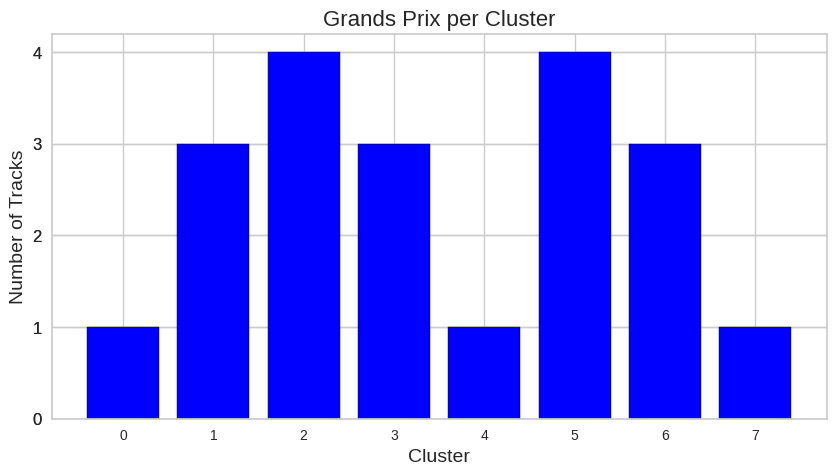

In [27]:
import matplotlib.pyplot as plt

cluster_counts = data_clusters.groupby("Cluster").size()

plt.figure(figsize=(10, 5))
plt.title("Grands Prix per Cluster", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Number of Tracks", fontsize=14)

plt.bar(cluster_counts.index, cluster_counts, color='blue', edgecolor='black', width=0.8)

plt.xticks(cluster_counts.index)
plt.yticks([int(i) for i in plt.yticks()[0]], fontsize=12)

plt.show()

Ici, nous visualisons la distribution des clusters, Nous notons plusieurs choses, par exemple, le cluster 2 et 5 sont les plus peuplés, avec 4 grands-prix chacun, suivi du cluster 1, 3 et 6 avec 3 grands-prix.

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> Track vizualization by Cluster</center></h3>

<div class="alert alert-block alert-info">
<b>Tip:</b> merge two dataFrames : tracks_points and clusters results dataframe.
    Use the function : track_vizualization_byCluster
    
</div>

In [28]:
###Appear track by Color
tracks_points = pd.merge(
    tracks_points, data_clusters[["grandprix", "Cluster"]], how="inner"
)


for track in tracks_points.grandprix.unique():
    temp_track_data = tracks_points[tracks_points["grandprix"] == track]
    track_vizualization_byCluster(temp_track_data, track)


#r1=tracks_points[tracks_points["grandprix"] == 'Russian Grand Prix']

Output hidden; open in https://colab.research.google.com to view.

Nous examinons ici les divers circuits des Grands Prix, permettant une analyse visuelle. Cela nous offre la possibilité d'émettre des hypothèses et peut-être de les confirmer visuellement, notamment pour comprendre pourquoi deux circuits sont regroupés dans le même cluster, par exemple.

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:lightgray; border:0' role="tab" aria-controls="home"><center> Make Clusters interpretation</center></h3>

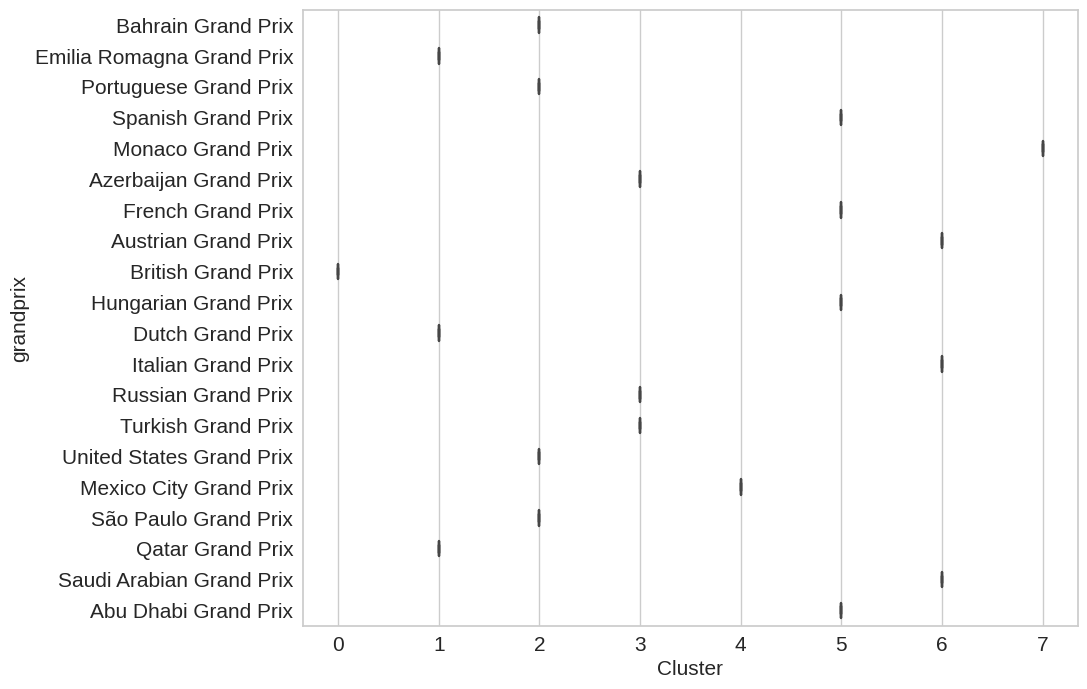

In [29]:
import seaborn as sns

variable_solo = prep_df.columns[0]
plt.figure(figsize=(10, 8))
sns.boxplot(y=prep_df[variable_solo], x=data_clusters["Cluster"], width=0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Cluster", fontsize=15)
plt.ylabel(variable_solo, fontsize=15)
plt.show()

On revoit ici la répartition des clusters, sous un autre angle d'affichage.

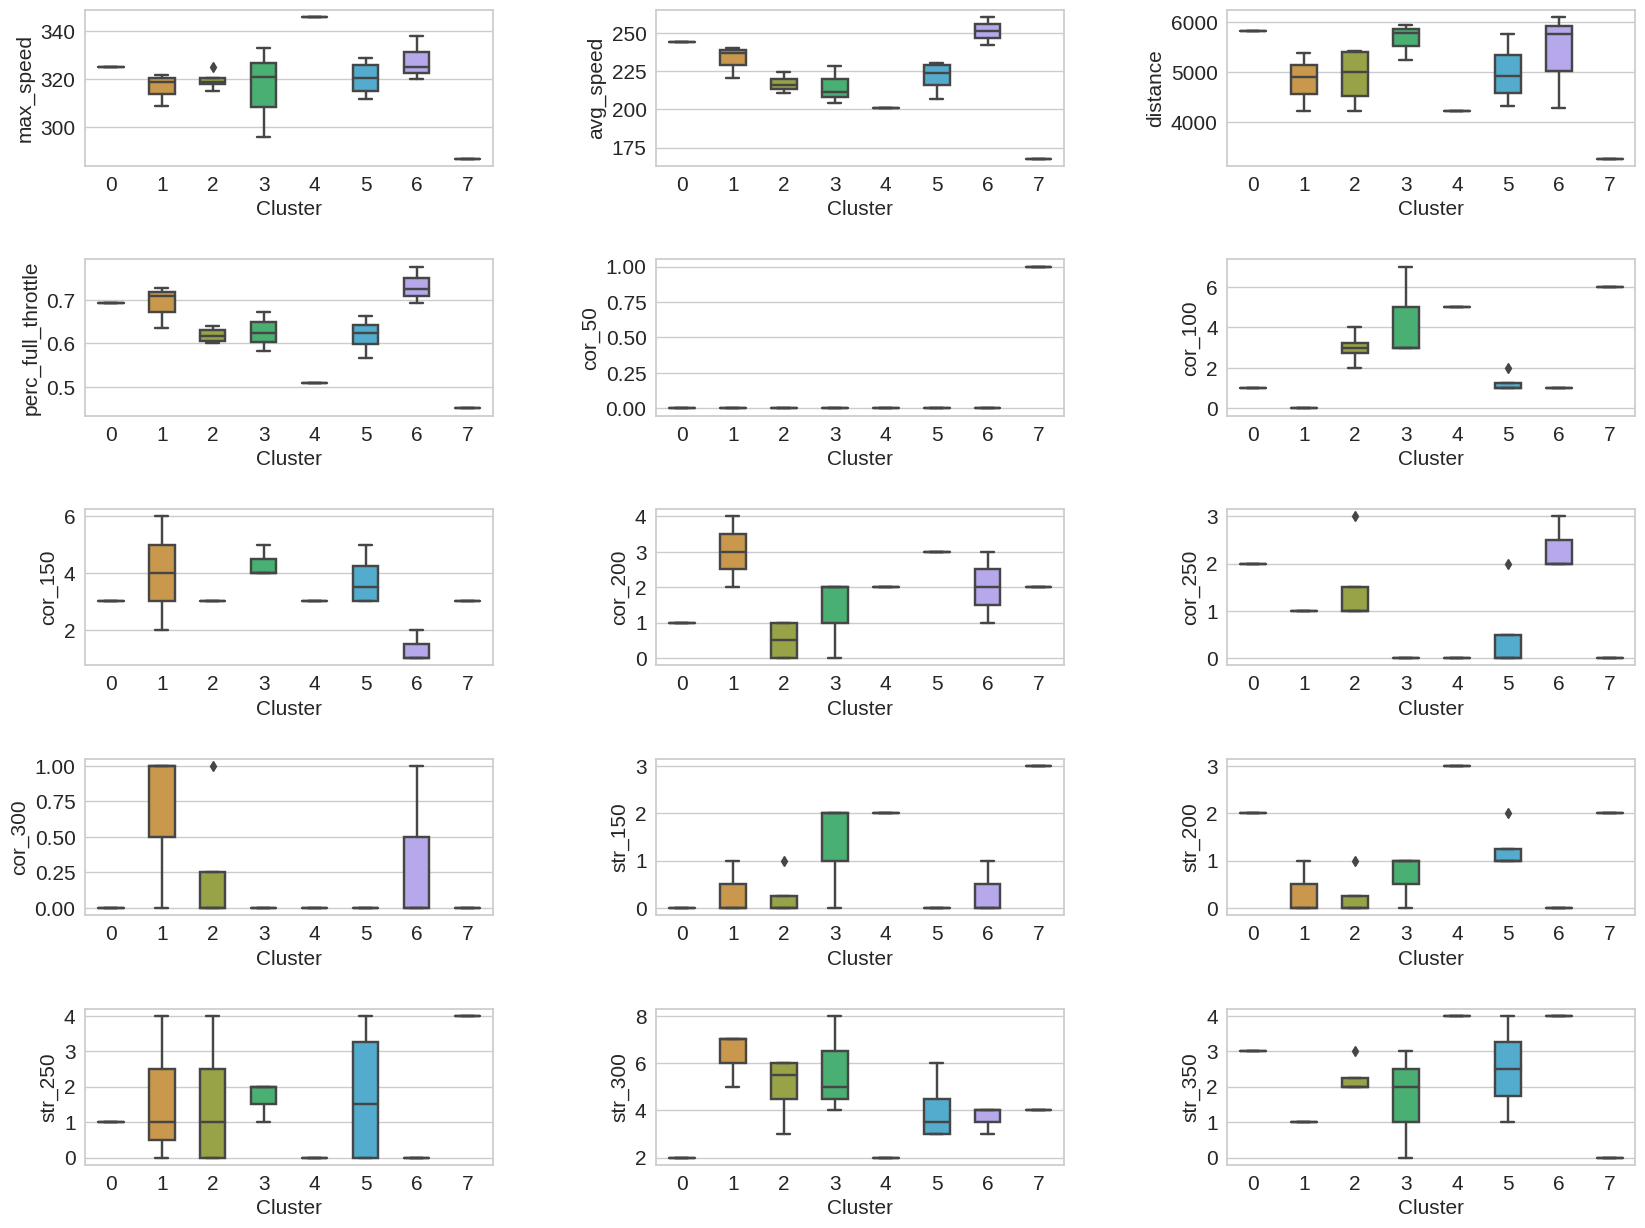

In [35]:
rows, cols = 5, 3
total_subplots = len(prep_df.columns)
plt.figure(figsize=(20, 15))  # Ajuste la hauteur pour agrandir les graphiques
plt.subplots_adjust(hspace=0.6, wspace=0.4)

for i, c in enumerate(prep_df.columns[1:]):
    plt.subplot(rows, cols, i % (rows * cols) + 1)
    sns.boxplot(y=prep_df[c], x=data_clusters["Cluster"], width=0.5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Cluster", fontsize=15)
    plt.ylabel(c, fontsize=15)

Nous examinons ici une abondance d'informations qui nous permettent de comprendre précisément les raisons et les méthodes derrière la répartition des clusters.

Les attributs tels que 'cor50', 'cor100', etc., représentent des caractéristiques spécifiques des données, en relation avec les vitesses dans les virages ou les sections droites des circuits, par exemple.

Concentrons-nous sur l'analyse des clusters les plus peuplés.

Prenons le cluster 2 comme exemple, où la vitesse maximale ainsi que la vitesse moyenne jouent un rôle essentiel, car toutes les valeurs sont regroupées autour de la moyenne. En revanche, la distance semble moins déterminante pour ce cluster, avec des valeurs déjà plus dispersées.

Quant au cluster 5, nous observons une modération, les valeurs ne sont pas aussi resserrées, mais restent significatives avec plusieurs attributs conservant leur importance.

De même, une analyse similaire peut être appliquée à tous les clusters. Des valeurs resserrées autour de la moyenne indiquent une similitude forte entre les membres du cluster, suggérant ainsi une importance particulière de cet attribut dans l'intégration du circuit au sein de ce cluster spécifique.